# Walk-forward Model Building

## Introduction

This is the fourth post in my series on transforming data into alpha.  If you haven't yet see the [framework overview](), [feature engineering guide](), or [feature_selection_guide](), please take a minute to read those first.  This post will build on the framework and philosophy presented there.  

This post is going to delve into the mechanics of _walk-forward modeling_ which is, in my view, the most robust way to train and apply machine learning models in inherently sequential domains like finance.  

## Motivation

The domain of market prediction presents several unique challenges for machine learning practitioners which do not exist in spam detection, natural language processing, image recognition, or other common areas of machine learning success.  In the future, I will write a longer treatise on these core challenges, but at the moment I'll just bullet-point them:
* __Low signal-to-noise ratio:__  adsfdfas
* __Non-stationarity (aka regime switching):__  adsfdfas
* __Market adaptation (aka reflexivity):__  adsfdfas

The combination of these challenges make it difficult to train and tune models which _generalize_ to the future, where it really matters.  This, in my view, has led many to conclude that markets cannot be predicted with machine learning techniques.

This is a flawed conclusion.  Instead, we should conclude that it's imperative to follow a modeling process which (1) avoids the trap of overfitting models to noise, (2) takes into account the sequential dimension of time series data, and (3) allows us to get an accurate view about how various models would have performed in the past _given the information we would have had at that time_.

"But wait!" I hear you saying, "Overfitting is not unique to market prediction!".  True, but the commonly used techniques of _train-test split_ and _cross-validation_ each have major flaws when applied to an inherently sequential set of financial time series data.

The overriding objective of the methods described here is to __overcome the issues inherent in traditional cross validation approachs__.   

### Issues with train-test split approach
One frequently recommended approach in finance ML tutorials is to split the data (commonly, by time) and to train on the first chunk of data and test out-of-sample on the second.  This is not wrong per se, but creates two problems:
1. Only a fraction of data can be used to generate out-of-sample performance of the model.  If you split 80/20, then you only get results for 2 of every 10 years of data.  Yuck.

2. You're implicitly biased towards the most recent period.  Since we're likely going to use the older data to train and newer data to test (for good reason...) you are implicitly searching for a model which was in favor during the most recent couple of years.  Maybe last year is a good approximation for next year, but maybe it's not.  Maybe 2008 would hold some important lessons for us to evaluate, but these would be lost to us.  

You might consider train/test split with random (or non-random) sampling but this creates other fairly obvious issues with peeking into the future.  

### Issues with cross-validation
In normal ML usage, cross-validation methods, such as the [K-fold cross validation](scikit), provide an elegant way to have our digital cake and eat it too.  However, with inherently sequential datasets, it's really not kosher to train a model on 2016 and 2018 to predict 2017.  

It's even less kosher to use all days except for June 23, 2017 to predict that day (i.e, [leave one out cross-validation](scikit).  

_These issues are especially intolerable if your model predicts values multiple bars in the future_, which results in your models being trained on data which significantly overlaps with your test data.

## The Solution: Walk-forward Train/Test
But we are not stuck with either of these problematic approaches.  The better - and I think much more intuitive - approach is to simulate models in a "walk-forward" sequence, periodically re-training the model to incorporate all data available at that point in time.  

The below picture is worth at least 1000 words.  Say we have six years of data to train + test.  At the end of the first year (T=1) we could have built model M1, which was trained on the first year's data (the grey bar).  After the 5th year, we could use up to five years of data to train model M5.  

![Foo](walkforward.png "Title")

## Getting Started
As in prior posts, we'll begin by fetching some real stock price data and then generating from it a synthetic dataset which will make it easier to follow the principles of this tutorial.  Please refer to the previous post [Feature Selection]() for further explanation of the how/why of this synthetic data step...   


In [170]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # remove once updated pandas-datareader issue is fixed
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline

def get_symbols(symbols,data_source, begin_date=None,end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date)[['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date','symbol'])
        out = pd.concat([out,df],axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO','AMZN','YHOO','MSFT'],data_source='quandl',begin_date='2012-01-01',end_date=None)
# note, we're only using real price data to get an accurate date/symbol index set.  

Similar to the [previous post](), we will generate some random data to serve as features _and then derive_ an outcome (response) variable from the features (to ensure that our made-up features will have ability to partially predict the target variable).  

However, this go around we'll add two non-random patterns to the data.  First, we will add some amount of "memory"  (autoregression) to the white noise with a short function called `add_memory()`.  This will make the data somewhat less random and more similar to actual markets - which I think we can all agree is not a purely gaussian random walk...  

Second, we'll add trend to the importance of each feature to the target variable to simulate the reality that various features - and the market factors they represent - move in and out of favor over time (aka "regime shift").  
* Feature `f01` is becoming more important
* Feature `f02` is becoming less important
* Feature `f03` is oscillating between very important and unimportant (using a sine wave pattern)
* Feature `f04` is not changing

In [434]:
num_obs = prices.close.count()

def add_memory(s,n_days=50,memory_strength=0.1):
    ''' adds autoregressive behavior to series of data'''
    add_ewm = lambda x: (1-memory_strength)*x + memory_strength*x.ewm(n_days).mean()
    out = s.groupby(level='symbol').apply(add_ewm)
    return out

# generate feature data
f01 = pd.Series(np.random.randn(num_obs),index=prices.index)
f01 = add_memory(f01,10,0.1)
f02 = pd.Series(np.random.randn(num_obs),index=prices.index)
f02 = add_memory(f02,10,0.1)
f03 = pd.Series(np.random.randn(num_obs),index=prices.index)
f03 = add_memory(f03,10,0.1)
f04 = pd.Series(np.random.randn(num_obs),index=prices.index)
f04 = f04 # no memory

## now, create response variable such that it is related to features
# f01 becomes increasingly important, f02 becomes decreasingly important,
# f03 oscillates in importance, f04 is stationary, finally a noise component is added

outcome =   f01 * np.linspace(0.5,1.5,num_obs) + \
            f02 * np.linspace(1.5,0.5,num_obs) + \
            f03 * pd.Series(np.sin(2*np.pi*np.linspace(0,1,num_obs)*2)+1,index=f03.index) + \
            f04 + \
            np.random.randn(num_obs) * 3 
outcome.name = 'outcome'

In [432]:
print(x)

[0.00000000e+00 1.30924326e-04 2.61848651e-04 ... 9.99738151e-01
 9.99869076e-01 1.00000000e+00]


So, we've now got four features which contain random and non-random elements, and we have an `outcome` target variable which can be partially explained by these features.   

Let's run a quick linear model to verify that this worked as expected:  

In [208]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
features = pd.concat([f01,f02,f03,f04],axis=1)
features.columns = ['f01','f02','f03','f04']
model.fit(X=features,y=outcome)
print('RSQ: '+str(model.score(X=features,y=outcome)))
print('Regression Coefficients: '+str(model.coef_))


RSQ: 0.26938944003973686
Regression Coefficients: [0.97842315 1.04320047 1.03708915 1.01329728]


Indeed.  A simple, linear model run on the entire dataset shows a remarkable (for this domain) RSQ of >0.25 and approximately equal coefficients for each of the features, suggesting that they're all contributing strongly to the model.  

However, this overlooks the very important reality that our data is non-stationary and what matters is how the model will _generalize_ to future, unseen data.  

To illustrate, I'll re-run the same model after splitting the data into train/test sets, with the first 80% used to train and the last 20% used to test.  


In [209]:
split_point = int(0.80*len(outcome))

X_train = features.iloc[:split_point,:] 
y_train = outcome.iloc[:split_point] 
X_test = features.iloc[split_point:,:] 
y_test = outcome.iloc[split_point:] 

model = LinearRegression()
model.fit(X=X_train,y=y_train)

print('RSQ in sample: '+str(model.score(X=X_train,y=y_train)))
print('RSQ out of sample: '+str(model.score(X=X_test,y=y_test)))
print('Regression Coefficients: '+str(model.coef_))

RSQ in sample: 0.29204993809396096
RSQ out of sample: 0.14714713925603085
Regression Coefficients: [0.89689467 1.14213245 1.2243406  0.97863658]


Here, the results tell a different story.  We see that the model's RSQ on the unseen test data degraded to only about half of the value on the training data.  Even if we were still satisfied with the degraded RSQ value, we would carry concern that perhaps the next period of time the models would degrade even further.  

This is where our walk-forward process comes in.


## The walk-forward approach
Here, I'll outline the basic design pattern for a robust approach to walk-forward modeling.  This is simplified.  In real-world usage, we'd likely add many enhancements but this will illustrate the concept.  

### Training models
The first step of the walk-forward approach is to train our model _using only the data available at any given point in time_.  Theoretically, we have new data every bar so could retrain the model daily if we wished.  However, for simplicity we'll retrain much less frequently - at the end of each calendar year.

We'll first create a list of timestamps for all end-of-year dates in our dataset.  These will become our days on which to retrain models.  Then, on each of the recalculation dates, we'll follow a simple procedure: 
1. slice out only the data which has happened up until that point
2. train a model with that data
3. save a copy of that fitted model object in a pandas Series called `models` which is indexed by the recalculation date.  

We could just as easily have used a dict or other data structure, but I find that pandas Series works well for this purpose.  Pandas is not just for numbers, after all...


In [313]:
recalc_dates = features.resample('Q',level='date').mean().index.values[:-1]
print('recalc_dates:')
print(recalc_dates)
print()

models = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(None,date),level='date',drop_level=False)
    y_train = outcome.xs(slice(None,date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models.loc[date] = model
    
    
    print("Training on the first {} records".format(len(y_train)))
    #print("Coefficients: {}".format((model.coef_)))
    #print()
    


recalc_dates:
['2012-03-31T00:00:00.000000000' '2012-06-30T00:00:00.000000000'
 '2012-09-30T00:00:00.000000000' '2012-12-31T00:00:00.000000000'
 '2013-03-31T00:00:00.000000000' '2013-06-30T00:00:00.000000000'
 '2013-09-30T00:00:00.000000000' '2013-12-31T00:00:00.000000000'
 '2014-03-31T00:00:00.000000000' '2014-06-30T00:00:00.000000000'
 '2014-09-30T00:00:00.000000000' '2014-12-31T00:00:00.000000000'
 '2015-03-31T00:00:00.000000000' '2015-06-30T00:00:00.000000000'
 '2015-09-30T00:00:00.000000000' '2015-12-31T00:00:00.000000000'
 '2016-03-31T00:00:00.000000000' '2016-06-30T00:00:00.000000000'
 '2016-09-30T00:00:00.000000000' '2016-12-31T00:00:00.000000000'
 '2017-03-31T00:00:00.000000000' '2017-06-30T00:00:00.000000000'
 '2017-09-30T00:00:00.000000000' '2017-12-31T00:00:00.000000000']

Training on the first 310 records
Training on the first 625 records
Training on the first 940 records
Training on the first 1250 records
Training on the first 1550 records
Training on the first 1870 recor

To visualize how the model is changing over time, I'll create a simple plotting function of coefficients:

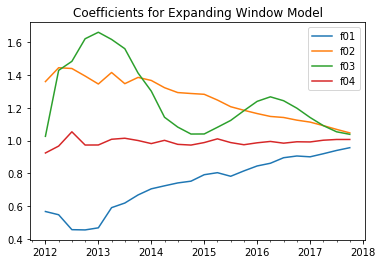

In [306]:
def extract_coefs(models):
    coefs = pd.DataFrame()
    for i,model in enumerate(models):
        model_coefs = pd.Series(model.coef_,index=['f01','f02','f03','f04']) #extract coefficients for model
        model_coefs.name = models.index[i] # name it with the recalc date
        coefs = pd.concat([coefs,model_coefs],axis=1)
    return coefs.T
extract_coefs(models).plot(title='Coefficients for Expanding Window Model')

Notice a few things about how the model's coefficients change over time:  
* The first feature gets increasing weight as it becomes a more important explanatory factor in the target variable,
* the second feature does just the opposite, as it should,
* the third feature oscillates before converging on a relatively lower endpoint, and 
* the fourth feature is mostly unchanged



But, in a world of constantly shifting regimes, we can do better.  

We know that, by the end fo the dataset, `f01` is actually much superior to `f02` however they end at about equal weights.  This is because in our final model building instance, we are using _all_ of our data to train, and this entire set of data correctly shows that _on average_ f02 is as useful as `f01`, ignoring that `f02`'s best days are long past.  



Training on the most recent 310 records
Training on the most recent 315 records
Training on the most recent 315 records
Training on the most recent 305 records
Training on the most recent 305 records
Training on the most recent 320 records
Training on the most recent 315 records
Training on the most recent 315 records
Training on the most recent 310 records
Training on the most recent 315 records
Training on the most recent 315 records
Training on the most recent 315 records
Training on the most recent 310 records
Training on the most recent 315 records
Training on the most recent 315 records
Training on the most recent 315 records
Training on the most recent 305 records
Training on the most recent 320 records
Training on the most recent 315 records
Training on the most recent 315 records
Training on the most recent 310 records
Training on the most recent 305 records
Training on the most recent 250 records
Training on the most recent 248 records


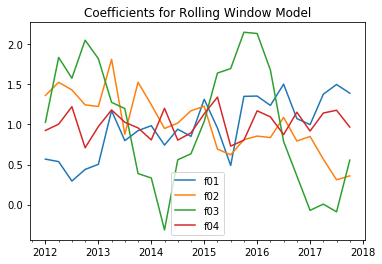

In [430]:
recalc_dates = features.resample('Q',level='date').mean().index.values[:-1]

models = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    y_train = outcome.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models.loc[date] = model
    
    print("Training on the most recent {} records".format(len(y_train)))
    #print("Coefficients: {}".format((model.coef_)))
    
extract_coefs(models).plot(title='Coefficients for Rolling Window Model')

This approach of only considering the 90 days' data prior to each model re-training has had a big impact.  We now see that `f01` has overtaken `f02` in significance by the end of the time period, as we'd hope.  The on-again, off-again feature `f03` has risen and fallen in prominence over time, again just as we'd hope.  

### Using models
The second stage of the process is _using_ these walk-forward models.  The process is similar and equally simple.  

First, we create two arrays, `begin_dates` and `end_dates`, which contain the dates on which each model is used.  For instance, for the first model (i=0), we will apply this model to features beginning on the date we trained the model (`recalc_date`) until the day the next model is trained.  The `end_dates` array therefore drops the 0th element and appends to the end a far-off date (in the year 2099).  

We can equally easily use this pattern to apply the models to true out of sample features.  As long as it's not later than the year 2099, we'll simply apply the latest and greatest model we have.  


In [354]:
begin_dates = models.index
end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

predictions = pd.Series(index=features.index)

for i,model in enumerate(models): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    p = pd.Series(model.predict(X),index=X.index)
    predictions.loc[X.index] = p

predictions.shape

(7639,)

So, this looped through each of the models we had trained at various points in time and, for each, used that model to predict the period of time until the next model became available.  It runs!  

Now we can confirm that the rolling model is, in fact, better than the "expanding" model by making predictions with each and comparing to truth.  

In [427]:
models_expanding_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(None,date),level='date',drop_level=False)
    y_train = outcome.xs(slice(None,date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models_expanding_window.loc[date] = model
    
models_rolling_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    y_train = outcome.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models_rolling_window.loc[date] = model
    
begin_dates = models.index
end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

predictions_expanding_window = pd.Series(index=features.index)
for i,model in enumerate(models_expanding_window): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    p = pd.Series(model.predict(X),index=X.index)
    predictions_expanding_window.loc[X.index] = p
    
predictions_rolling_window = pd.Series(index=features.index)
for i,model in enumerate(models_rolling_window): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    p = pd.Series(model.predict(X),index=X.index)
    predictions_rolling_window.loc[X.index] = p

In [428]:
from sklearn.metrics import r2_score

common_idx = outcome.dropna().index.intersection(predictions_expanding_window.dropna().index)
rsq_expanding = r2_score(y_true = outcome[common_idx],y_pred=predictions_expanding_window[common_idx])
rsq_rolling = r2_score(y_true = outcome[common_idx],y_pred=predictions_rolling_window[common_idx])

print("Expanding Window RSQ: {}".format(round(rsq_expanding,3)))
print("Rolling Window RSQ: {}".format(round(rsq_rolling,3)))



Expanding Window RSQ: 0.262
Rolling Window RSQ: 0.286


Great!  All of that work added about 2.4 points of RSQ, which is certainly worth the effort.  

### Avoiding complexity
The value of this walk-forward methodology is greatest when it helps you to avoid the scourge of overfitting.  The linear regression model used up to this point is relatively resistant to overfit, since it has few parameters.  

Let's say that, instead of a simple linear regression, we used the much more overfit-prone DecisionTree, which has tendency to "memorize the past" rather than to recognize patterns in it.      

In [424]:
from sklearn.tree import DecisionTreeRegressor

split_point = int(0.80*len(outcome))

X_train = features.iloc[:split_point,:] 
y_train = outcome.iloc[:split_point] 
X_test = features.iloc[split_point:,:] 
y_test = outcome.iloc[split_point:] 

model = DecisionTreeRegressor(max_depth=3)
model.fit(X=X_train,y=y_train)

print('RSQ in sample: '+str(round(model.score(X=X_train,y=y_train),3)))
print('RSQ out of sample: '+str(round(model.score(X=X_test,y=y_test),3)))


RSQ in sample: 0.177
RSQ out of sample: 0.018


This leads to overfit disaster!  Now, we'll do the same with our walk-forward framework:

In [425]:
recalc_dates = features.resample('Q',level='date').mean().index.values[:-1]

models_rolling_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(date-pd.Timedelta('365 days'),date),level='date',drop_level=False)
    y_train = outcome.xs(slice(date-pd.Timedelta('365 days'),date),level='date',drop_level=False)
    model = DecisionTreeRegressor(max_depth=3)
    model.fit(X_train,y_train)
    models_rolling_window.loc[date] = model
    
predictions_rolling_window = pd.Series(index=features.index)
for i,model in enumerate(models_rolling_window): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    p = pd.Series(model.predict(X),index=X.index)
    predictions_rolling_window.loc[X.index] = p

common_idx = y_test.dropna().index.intersection(predictions_rolling_window.dropna().index)
rsq_rolling = r2_score(y_true = y_test[common_idx],y_pred=predictions_rolling_window[common_idx])
print("RSQ out of sample): {}".format(round(rsq_rolling,3)))


RSQ out of sample): 0.082


Much, much better.  While the RSQ result ain't great (much worse than the linear regression model), that's much preferred to being fooled by an extraordinarily overfitted result like above.  We could have guessed that `DecisionTree` would be a silly model type to try in this situation but it illustrates the point.  

## Summary
That, in a nutshell, is the walk-forward modeling framework.  The key points to keep in mind are:
* Traditional methods of validation and cross-validation are problematic for time series prediction problems
* The solution is to use a "walk-forward" approach which incorporates new information as it becomes available.
* This approach gives us a more realistic view of how effective our model would truly have been in the past, and helps to avoid the overfitting trap.
* In addition to excluding any future data from the training process, it's often important to exclude data which is too far in the past.  

In the [next post]() of this series, I will present a framework for scoring and comparing models which is more complete and useful than generic machine learning methods.